Project: Mod 3 Final Project - Northwind Database Hypothesis Testing

Student: Douglas Steen

Instructor: James Irving, PhD

Date of Project Review:

Cohort: ds-ft-10072019

# Project Overview 
The purpose of this study is to  perform specific hypothesis tests to gain actionable insights that can be used by Northwind managment to improve business strategy and efficiency. The study aims to answer the following questions, and provide recommendations based on the results.

Question # 1:
Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

Question # 2:
Does the shipper used have a statistically significant effect on freight price?

Question # 3:
Does the specific employee have a statistically significant effect on the number of repeat orders their customers make?

Question # 4:
Does the time of year have a statistically significant effect on quantity of a product ordered?

# Import Libraries & Connect to Database

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [3]:
pip install scikit-posthocs


Note: you may need to restart the kernel to use updated packages.


In [4]:
import scikit_posthocs as sp


In [5]:
# Instantiate a cursor object and connect to the Northwind sqlite database

conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

# Class: DistChecker
This is a class of functions that I will use to: 1) Test normality of distributioons, 2) plot distributions, 3) return basic summary info for a given distribution.

In [6]:
class DistChecker():

    def __init__(self, X, name):
        self.X = X
        self.name = name

    def norm_tests(self, alpha=0.05, dist='norm'):
        import scipy.stats as stats
        self.alpha = alpha
        self.dist = dist

        # Shapiro-Wilk Test
        self.W, self.p_val1 = stats.shapiro(self.X)
        if self.p_val1 <= alpha:
            print(f'SHAPIRO-WILK TEST at alpha = {self.alpha}:')
            print(
                f'The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = {self.p_val1}\n')
        else:
            print(f'SHAPIRO-WILK TEST at alpha = {self.alpha}:')
            print(
                f'The null hypothesis that sample data was drawn from a normal distribution is NOT REJECTED at p = {self.p_val1}\n')

        # D'Agostino-Person Test
        self.st, self.p_val2 = stats.normaltest(self.X)
        if self.p_val1 <= alpha:
            print(f"D'AGOSTINO-PEARSON TEST at alpha = {self.alpha}:")
            print(
                f'The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = {self.p_val2}\n')
        else:
            print(f"D'AGOSTINO-PEARSON TEST at alpha = {self.alpha}:")
            print(
                f'The null hypothesis that sample was drawn from a normal distribution is NOT REJECTED at p = {self.p_val2}\n')

        # Anderson-Darling Test
        self.statistic, self.crit, self.sig = stats.anderson(self.X, self.dist)
        # This compares statistic to critical value at alpha=0.05
        if self.statistic > self.crit[2]:
            print(f"ANDERSON-DARLING TEST at alpha = {self.alpha}:")
            print(
                f'The null hypothesis that sample was drawn from a normal distribution is REJECTED.')
            print(
                f'Test Statistic: {self.statistic} > Critical Value {self.crit[2]}')
        else:
            print(f"ANDERSON-DARLING TEST at alpha = {self.alpha}:")
            print(
                f'The null hypothesis that sample was drawn from a normal distribution is NOT REJECTED.')
            print(
                f'Test Statistic: {self.statistic} < Critical Value {self.crit[2]}')

    def plot_dist(self):

        plt.figure(figsize=(6,6))
        sns.distplot(self.X, color='black')
        plt.axvline(np.mean(self.X), linewidth=3, c='blue',
                    label=f'Mean = {round(np.mean(self.X),2)}', linestyle='--')
        plt.ylabel('Prob')
        plt.title(self.name + ' Distribution')
        plt.legend()
        plt.show()

    def summary_info(self):
        nulls = self.X.isnull().sum()
        print(f'{self.name} distribution summary statistics:\n\n', self.X.describe())
        print(f'\n\n{self.name} distribution value counts:\n\n', self.X.value_counts())
        print(f'\n{self.name} data contains {nulls} null values.\n')
        

# Function: Cohen_d

In [7]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

# Question # 1a: Discount & Order Quantity

Question: (1a) Does discount amount have a statistically significant effect on the quantity of a product in an order? (1b) If so, at what level(s) of discount?

Null Hypothesis: Discount amount (at all levels) has no effect on the quantity of a product in an order.

Alt. Hypothesis: When a discount is present, the quantity of a product in an order is higher than if there is no discount.

## Obtain

Obtain necessary data from Northwind SQL database to answer Question #1

-Want to visualize all variables in the OrderDetail table


In [8]:
# Obtain OrderDetail table, create a pandas dataframe for all entries with no (0) discount
cur.execute("""SELECT * FROM OrderDetail WHERE Discount == 0;""")
q1df_nd = pd.DataFrame(cur.fetchall())
q1df_nd.columns = [x[0] for x in cur.description]
q1df_nd.drop(labels='Id', inplace=True, axis=1)
q1df_nd.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [9]:
# Obtain OrderDetail table, create a pandas dataframe with results for any level of discount > 0
cur.execute("""SELECT * FROM OrderDetail WHERE Discount > 0;""")
q1df_d = pd.DataFrame(cur.fetchall())
q1df_d.columns = [x[0] for x in cur.description]
q1df_d.drop(labels='Id', inplace=True, axis=1)
q1df_d.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250,51,42.4,35,0.15
1,10250,65,16.8,15,0.15
2,10251,22,16.8,6,0.05
3,10251,57,15.6,15,0.05
4,10252,20,64.8,40,0.05


In [10]:
# Save the desired variables (pull quantity from each dataframe)

A1 = q1df_nd.Quantity
B1= q1df_d.Quantity

## Scrub / Explore

Visualize distributions, edit problem values if necessary.

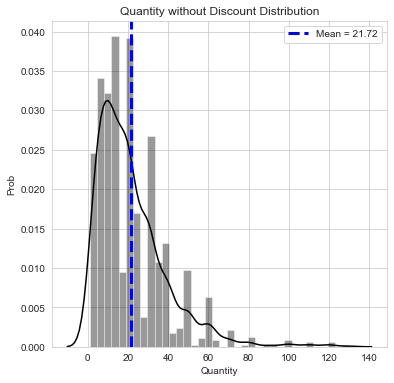

Quantity without Discount distribution summary statistics:

 count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64


Quantity without Discount distribution value counts:

 20     154
10     130
30     122
15     100
6       62
40      60
12      57
5       53
25      44
35      42
50      40
4       39
24      36
3       34
2       30
21      30
60      30
8       29
14      28
18      24
9       22
16      21
28      18
7       17
1       13
70      10
36       9
45       9
42       8
80       6
55       4
100      4
120      3
32       3
48       3
49       3
65       3
110      3
39       2
44       2
130      1
13       1
22       1
52       1
56       1
63       1
77       1
90       1
91       1
33       1
Name: Quantity, dtype: int64

Quantity without Discount data contains 0 null values.

SHAPIRO-WILK TEST at alpha = 0.05:
The null hyp

In [11]:
# Check distribution of Quantities with no Discount
q1_nd = DistChecker(A1, 'Quantity without Discount')
q1_nd.plot_dist()
q1_nd.summary_info()
q1_nd.norm_tests()

This distribution is clearly NOT normally distributed, with a mean of 21.7, contains 1317 values, no null/missing.

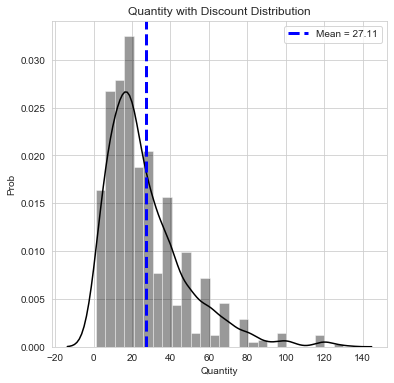

Quantity with Discount distribution summary statistics:

 count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64


Quantity with Discount distribution value counts:

 20     98
30     72
15     69
40     53
10     51
25     36
50     35
12     35
35     29
60     28
6      25
18     23
24     22
2      22
8      21
21     20
70     18
4      16
5      14
16     14
36     12
3      12
42     11
28     11
80     10
14      8
9       8
7       6
100     6
55      5
65      5
45      5
120     5
1       4
49      4
90      3
11      2
32      2
13      2
27      2
44      2
48      2
56      2
77      2
84      2
33      1
54      1
66      1
130     1
Name: Quantity, dtype: int64

Quantity with Discount data contains 0 null values.

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 6

In [12]:
# Check distribution of Quantities with Discount
q1_d = DistChecker(B1, 'Quantity with Discount')
q1_d.plot_dist()
q1_d.summary_info()
q1_d.norm_tests()

This distribution is clearly NOT normally distributed, with a mean of 27.1, contains 838 values, and no null/missing values.

## Test: Welch's 2-sample t-test

Does discount amount have a statistically significant effect on the quantity of a product in an order?

In [13]:
# Since sample size is very large (n>20), we can ignore the normality assumption here and use a Welch's two-sample t-test.

t_1, p_1 = stats.ttest_ind(A1, B1, equal_var=False)
print(f't-statistic: {t_1}')
print(f'p_value: {p_1}')

t-statistic: -6.239069142123973
p_value: 5.65641429030433e-10


In [14]:
# Just as a check, run non-parametric Mann-Whitney Test to confirm/deny result

stats.mannwhitneyu(A1, B1, alternative='two-sided')

MannwhitneyuResult(statistic=461541.0, pvalue=1.3258763653999732e-10)

## Interpretation

As a result of the significant result of the welch's t-test, we can reject the null hypothesis that discount has no effect on the quantity of a product in an order.

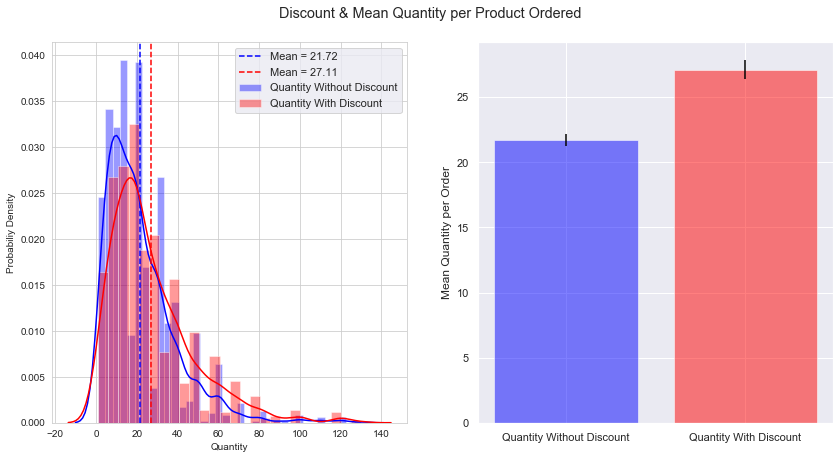

In [15]:
# Some code to plot the two distributions ontop of each other (add to function (& class?) later.)

plt.figure(figsize=(14, 7))
plt.subplot(121)
sns.set_style('darkgrid')
sns.set_context('notebook')
ax1 = sns.distplot(A1, color='blue', label='Quantity Without Discount')
plt.axvline(x=np.mean(A1), linestyle='--', color='blue',
            label=f'Mean = {round(np.mean(A1), 2)}')
ax2 = sns.distplot(B1, color='red', label='Quantity With Discount')
plt.axvline(x=np.mean(B1), linestyle='--', color='red',
            label=f'Mean = {round(np.mean(B1), 2)}')
plt.ylabel('Probabiliy Density')
plt.legend()

plt.subplot(122)
sns.set_style('darkgrid')
sns.set_context('notebook')
plt.bar(x='Quantity Without Discount', height=np.mean(
    A1), color='blue', alpha=0.5, yerr=stats.sem(A1))
plt.bar(x='Quantity With Discount', height=np.mean(
    B1), color='red', alpha=0.5, yerr=stats.sem(B1))
plt.ylabel('Mean Quantity per Order')
plt.suptitle('Discount & Mean Quantity per Product Ordered', y=0.95)
plt.show()

### Sub-Question 1a
What is the statistical power of this test?

In [16]:
# First, must calculate cohen's d (effect size)
q1a_cd = Cohen_d(B1, A1)
print(q1a_cd)

0.2862724481729282


In [17]:
# Then, use statsmodels TTestIndPower class to help solve for power
from statsmodels.stats.power import TTestIndPower

In [18]:
power_analysis = TTestIndPower()

In [19]:
# Solve for statistical power
alpha = 0.05
nobs1 = 838
nobs2 = 1317
ratio = nobs1 / nobs2

q1a_pow = power_analysis.solve_power(
    effect_size=q1a_cd, nobs1=nobs1, alpha=alpha, ratio=ratio)
print(
    f'The statistical power is {round(q1a_pow, 2)}, and the Type II (false negative) error rate for this test is {1 - round(q1a_pow, 2)}.')

The statistical power is 1.0, and the Type II (false negative) error rate for this test is 0.0.


## Conclusion: Question 1a

A two-sample welch's t-test indicates that there is a statistically significant relationship between the presence of a discount and the quantity of a product in an order. Though neither group's sample distribution is normal, the large sample size in each group allows us to use the parametric 2-sample Welch's t-test. The difference between the mean quantities of the groups is ~ 5.5 items per product per order. At a Type I (false positive) error rate (alpha) of 0.05, the calculated Cohen's d effect size is relatively small (0.286), however, due to the large sample sizes, the statistical power is 1.0. Therefore, the Type II (false negative) error rate is effectively 0.

# Question # 1b: Level of Discount & Order Quantity
At what level(s) of discount is there a statistically significant effect on the quantity of a product in an order?

## Obtain

In [20]:
# Obtain OrderDetail table, create a pandas dataframe for all entries
cur.execute("""SELECT * FROM OrderDetail;""")
q1bdf = pd.DataFrame(cur.fetchall())
q1bdf.columns = [x[0] for x in cur.description]
q1bdf.drop(labels='Id', inplace=True, axis=1)
q1bdf.tail()

,OrderId,ProductId,UnitPrice,Quantity,Discount
2150,11077,64,33.25,2,0.03
2151,11077,66,17.00,1,0.00
2152,11077,73,15.00,2,0.01
2153,11077,75,7.75,4,0.00
2154,11077,77,13.00,2,0.00


## Test: Tukey's HSD Multiple Comparison

To compare the level at which a discount has a signficant effect on the quantity of a product ordered, I am using Tukey's honestly significant difference (HSD) test, a single step multiple comparison procedure. This is a post-hoc test to help determine WHICH discount levels have significantly different product order quantites (now that we know that a difference exists in order quantity between the 'discount' and 'no-discount' groups).

In [21]:
q1b_result = sm.stats.multicomp.pairwise_tukeyhsd(endog=q1bdf.Quantity, groups=q1bdf.Discount)

In [22]:
q1b_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
0.0,0.05,6.2955,0.0011,1.5381,11.053,True
0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
0.0,0.15,6.6669,0.0014,1.551,11.7828,True
0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
0.0,0.25,6.525,0.0023,1.3647,11.6852,True


## Conclusion: Question 1b

To compare the level at which a discount has a signficant effect on the quantity of a product ordered, I used Tukey's honestly significant difference (HSD) test, a single step multiple comparison procedure. The results of this test indicate that for most levels of discount 5% and above, we can reject the null hypothesis that there is no difference in quantity ordered between the means of the control (0% discount) group and experimental groups (any level of discount).

# Question # 2: Shipper & Freight Price
Question: (2) Does the shipper used have a statistically significant effect on the average freight cost for a shipment?

Null Hypothesis: Shipper has no significant effect on the freight cost for a shipment.

Alt. Hypothesis: There is a significant difference in freight cost between different shippers.

## Obtain

Load both Shipper and Order tables from SQL database

In [23]:
# Get Shipper table from database
cur.execute("""SELECT * 
            FROM Shipper;""")
shipper_df = pd.DataFrame(cur.fetchall())
shipper_df.columns = [x[0] for x in cur.description]
shipper_df.drop(labels='Id', inplace=True, axis=1)
shipper_df.head()

,CompanyName,Phone
0,Speedy Express,(503) 555-9831
1,United Package,(503) 555-3199
2,Federal Shipping,(503) 555-9931


In [24]:
# Get Order table from database
cur.execute("""SELECT * 
            FROM 'Order';""")
order_df = pd.DataFrame(cur.fetchall())
order_df.columns = [x[0] for x in cur.description]
order_df.drop(labels='Id', inplace=True, axis=1)
order_df.head()

,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


## Scrub / Explore

Subsetting Orders table by shipper used (ShipVia == 1, 2, OR 3)

In [25]:
cur.execute("""SELECT * FROM 'Order' WHERE ShipVia == 1;""")
s1_df = pd.DataFrame(cur.fetchall())
s1_df.columns = [x[0] for x in cur.description]
s1_df.drop(labels='Id', inplace=True, axis=1)
s1_df.head()

cur.execute("""SELECT * FROM 'Order' WHERE ShipVia == 2;""")
s2_df = pd.DataFrame(cur.fetchall())
s2_df.columns = [x[0] for x in cur.description]
s2_df.drop(labels='Id', inplace=True, axis=1)
s2_df.head()

cur.execute("""SELECT * FROM 'Order' WHERE ShipVia == 3;""")
s3_df = pd.DataFrame(cur.fetchall())
s3_df.columns = [x[0] for x in cur.description]
s3_df.drop(labels='Id', inplace=True, axis=1)
s3_df.head()

,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,RICSU,9,2012-07-12,2012-08-09,2012-07-15,3,148.33,Richter Supermarkt,Starenweg 5,Genève,Western Europe,1204,Switzerland
2,HILAA,4,2012-07-16,2012-08-13,2012-07-22,3,81.91,HILARION-Abastos,Carrera 22 con Ave. Carlos Soublette #8-35,San Cristóbal,South America,5022,Venezuela
3,CENTC,4,2012-07-18,2012-08-15,2012-07-25,3,3.25,Centro comercial Moctezuma,Sierras de Granada 9993,México D.F.,Central America,05022,Mexico
4,RATTC,8,2012-07-22,2012-08-19,2012-07-25,3,48.29,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA


In [26]:
# For loop to generate the freight price datasets for each shipper
shippers = [s1_df, s2_df, s3_df]
freight_dists=[]
for df in shippers:
    freight_dists.append(df.Freight)
    
print(freight_dists)

[0       11.61
1       41.34
2      140.51
3       55.09
4       55.28
        ...  
244      0.33
245     30.09
246     12.91
247    136.00
248      0.93
Name: Freight, Length: 249, dtype: float64, 0      65.83
1      51.30
2      58.17
3      22.98
4      13.97
       ...  
321    24.95
322    18.44
323     6.19
324    38.28
325     8.53
Name: Freight, Length: 326, dtype: float64, 0       32.38
1      148.33
2       81.91
3        3.25
4       48.29
        ...  
250     24.12
251      2.79
252      4.13
253     31.14
254     14.01
Name: Freight, Length: 255, dtype: float64]


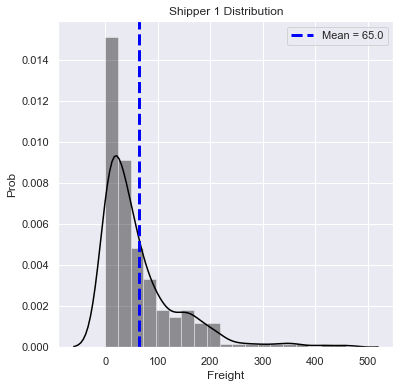

Shipper 1 distribution summary statistics:

 count    249.000000
mean      65.001325
std       75.393587
min        0.120000
25%       12.750000
50%       40.420000
75%       89.900000
max      458.780000
Name: Freight, dtype: float64


Shipper 1 distribution value counts:

 12.69     2
1.36      2
188.04    1
63.20     1
69.19     1
         ..
10.19     1
38.06     1
2.91      1
200.24    1
12.75     1
Name: Freight, Length: 247, dtype: int64

Shipper 1 data contains 0 null values.

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.024363869389547e-18

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.1898236398446387e-28

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 15.953834477999408 > Critical Value 0.775


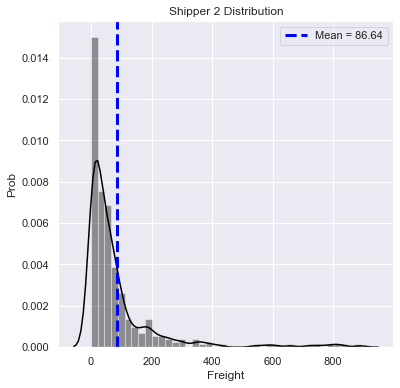

Shipper 2 distribution summary statistics:

 count    326.000000
mean      86.640644
std      138.219262
min        0.020000
25%       14.040000
50%       44.135000
75%       91.430000
max      890.780000
Name: Freight, dtype: float64


Shipper 2 distribution value counts:

 3.26      2
23.72     2
0.56      2
1.35      2
6.27      2
         ..
3.05      1
60.43     1
1.15      1
156.66    1
22.00     1
Name: Freight, Length: 319, dtype: int64

Shipper 2 data contains 0 null values.

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.954606683318374e-27

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.1480923009081493e-57

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 40.34253113699663 > Critical Value 0.778


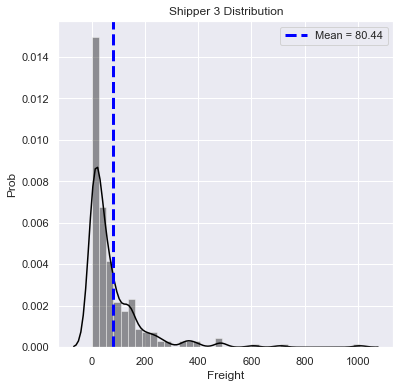

Shipper 3 distribution summary statistics:

 count     255.000000
mean       80.441216
std       119.362844
min         0.400000
25%        12.860000
50%        36.710000
75%        99.490000
max      1007.640000
Name: Freight, dtype: float64


Shipper 3 distribution value counts:

 32.01     1
4.07      1
13.99     1
8.85      1
144.38    1
         ..
145.04    1
29.78     1
4.32      1
229.24    1
3.25      1
Name: Freight, Length: 255, dtype: int64

Shipper 3 data contains 0 null values.

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 3.371958171463351e-23

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.1224208469747222e-50

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 25.26923529014107 > Critical Value 0.775


In [27]:
# Use DistChecker class to check normality/characteristics of distributions and select a test
shipper_num = 0
for i in freight_dists:
    shipper_num += 1
    dist = DistChecker(i, f'Shipper {shipper_num}')
    dist.plot_dist()
    dist.summary_info()
    dist.norm_tests()

The data are not normally distributed, but it appears that each sample would benefit from outlier removal.

In [28]:
freight_dists[0].to_list()

[11.61,
 41.34,
 140.51,
 55.09,
 55.28,
 208.58,
 4.56,
 136.54,
 6.01,
 26.93,
 8.98,
 2.94,
 12.69,
 76.56,
 7.45,
 79.7,
 0.12,
 47.3,
 12.69,
 4.88,
 214.27,
 63.36,
 12.75,
 10.19,
 110.37,
 8.63,
 162.33,
 41.95,
 19.64,
 96.04,
 71.97,
 0.45,
 45.03,
 94.77,
 34.86,
 126.38,
 184.41,
 60.26,
 12.51,
 155.97,
 34.82,
 108.04,
 11.26,
 29.83,
 0.2,
 17.55,
 44.12,
 99.23,
 3.02,
 18.69,
 11.09,
 458.78,
 19.97,
 13.95,
 9.3,
 14.68,
 140.26,
 11.57,
 16.27,
 6.17,
 11.93,
 60.18,
 4.2,
 68.52,
 62.89,
 36.21,
 42.68,
 69.32,
 47.45,
 0.15,
 105.65,
 204.47,
 13.37,
 45.33,
 41.9,
 8.12,
 188.04,
 15.64,
 78.85,
 68.65,
 24.91,
 171.24,
 83.22,
 9.8,
 8.05,
 36.65,
 22.95,
 88.4,
 33.97,
 58.98,
 127.34,
 3.01,
 59.14,
 13.41,
 0.48,
 62.52,
 55.92,
 32.1,
 96.78,
 16.34,
 45.13,
 58.3,
 7.46,
 200.24,
 26.78,
 154.68,
 43.9,
 0.87,
 41.38,
 1.15,
 201.29,
 158.44,
 23.55,
 29.46,
 12.41,
 93.25,
 55.26,
 57.15,
 364.15,
 111.29,
 78.09,
 24.39,
 203.48,
 30.34,
 22.76,
 26.61,
 4

In [29]:
out_rem_data = []

for i in freight_dists:
    q1, q3 = np.percentile(a=i, q=[25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    fr_out = i.to_list()
    for obs in fr_out:
        if obs < lower_bound or obs > upper_bound:
            fr_out.remove(obs)
        else: 
            continue
    out_rem_data.append(fr_out)

#     outliers.append(list(
#         df_scrub[(df_scrub[col] < lower_bound) | (df_scrub[col] > upper_bound)].index))


out_rem_data

[[11.61,
  41.34,
  140.51,
  55.09,
  55.28,
  4.56,
  136.54,
  6.01,
  26.93,
  8.98,
  2.94,
  12.69,
  76.56,
  7.45,
  79.7,
  0.12,
  47.3,
  12.69,
  4.88,
  63.36,
  12.75,
  10.19,
  110.37,
  8.63,
  162.33,
  41.95,
  19.64,
  96.04,
  71.97,
  0.45,
  45.03,
  94.77,
  34.86,
  126.38,
  184.41,
  60.26,
  12.51,
  155.97,
  34.82,
  108.04,
  11.26,
  29.83,
  0.2,
  17.55,
  44.12,
  99.23,
  3.02,
  18.69,
  11.09,
  19.97,
  13.95,
  9.3,
  14.68,
  140.26,
  11.57,
  16.27,
  6.17,
  11.93,
  60.18,
  4.2,
  68.52,
  62.89,
  36.21,
  42.68,
  69.32,
  47.45,
  0.15,
  105.65,
  204.47,
  13.37,
  45.33,
  41.9,
  8.12,
  188.04,
  15.64,
  78.85,
  68.65,
  24.91,
  171.24,
  83.22,
  9.8,
  8.05,
  36.65,
  22.95,
  88.4,
  33.97,
  58.98,
  127.34,
  3.01,
  59.14,
  13.41,
  0.48,
  62.52,
  55.92,
  32.1,
  96.78,
  16.34,
  45.13,
  58.3,
  7.46,
  200.24,
  26.78,
  154.68,
  43.9,
  0.87,
  41.38,
  1.15,
  201.29,
  158.44,
  23.55,
  29.46,
  12.41,
  93.25,

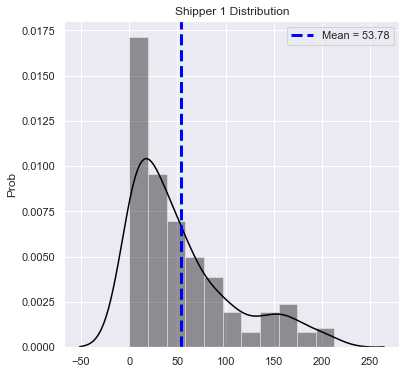

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.7612072987770984e-14

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 4.1698969876157934e-10

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 11.402229551826736 > Critical Value 0.774

238 observations in Shipper 1


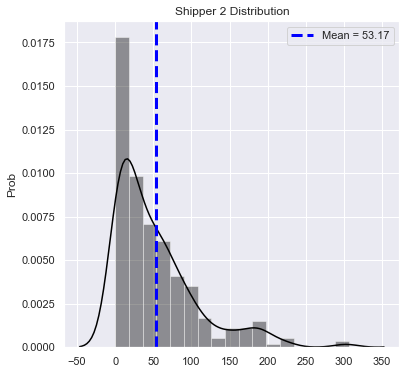

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.8585742512441667e-17

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 3.6148874537385146e-23

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 13.978704935030635 > Critical Value 0.777

299 observations in Shipper 2


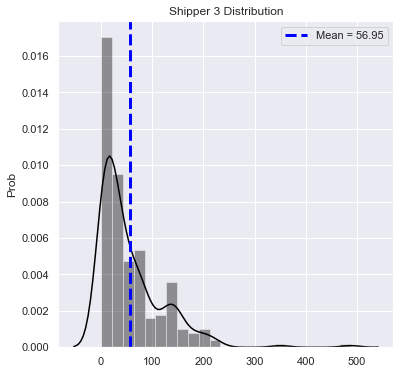

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.1838197818094493e-17

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.2181893996358094e-31

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 13.209254925836234 > Critical Value 0.774

238 observations in Shipper 3


In [30]:
# Use DistChecker class to check normality/characteristics of data after outlier removal
shipper_num = 0
for i in out_rem_data:
    shipper_num += 1
    dist = DistChecker(i, f'Shipper {shipper_num}')
    dist.plot_dist()
    dist.norm_tests()
    print(f'\n{len(i)} observations in Shipper {shipper_num}')

Do these data meet the requirements for a one-way ANOVA test?

1) Is each record in data distinct and independent? -> Yes

2) Are samples normally distriuted, or is N >= 25? -> Yes

3) Is homogeneity of variance present? (Only needed for sharply unequal sample sizes) -> No (But sample sizes are not 'SHARPLY' unequal (238 vs 299 vs 238), so this assumption is met.)

Therefore, I conclude that the one-way ANOVA is suitable for these samples, but I will also perform a Kruskal-Wallis test as a non-parametric check.

## Test: One-Way ANOVA (Kruskal-Wallis)

In [31]:
f_st, p_val = stats.f_oneway(out_rem_data[0], out_rem_data[1], out_rem_data[2])
alpha = 0.05
if p_val <0.05:
    print('ONE-WAY ANOVA TEST RESULT:\n')
    print(f'The null hypothesis IS rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')
else:
    print('ONE-WAY ANOVA TEST RESULT:\n')
    print(f'The null hypothesis is NOT rejected at alpha={alpha}, with a p-value of {round(p_val,3)}') 

ONE-WAY ANOVA TEST RESULT:

The null hypothesis is NOT rejected at alpha=0.05, with a p-value of 0.728


In [32]:
st, p_val = stats.kruskal(out_rem_data[0], out_rem_data[1], out_rem_data[2])
alpha = 0.05
if p_val <0.05:
    print('KRUSKAL-WALLIS TEST RESULT:\n')
    print(f'The null hypothesis IS rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')
else:
    print('KRUSKAL-WALLIS TEST RESULT:\n')
    print(f'The null hypothesis is NOT rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')

KRUSKAL-WALLIS TEST RESULT:

The null hypothesis is NOT rejected at alpha=0.05, with a p-value of 0.991


In [33]:
# Creating dictionary of data for plotting
names = ['Shipper 1', 'Shipper 2', 'Shipper 3']
q2_data = dict(zip(names, out_rem_data))

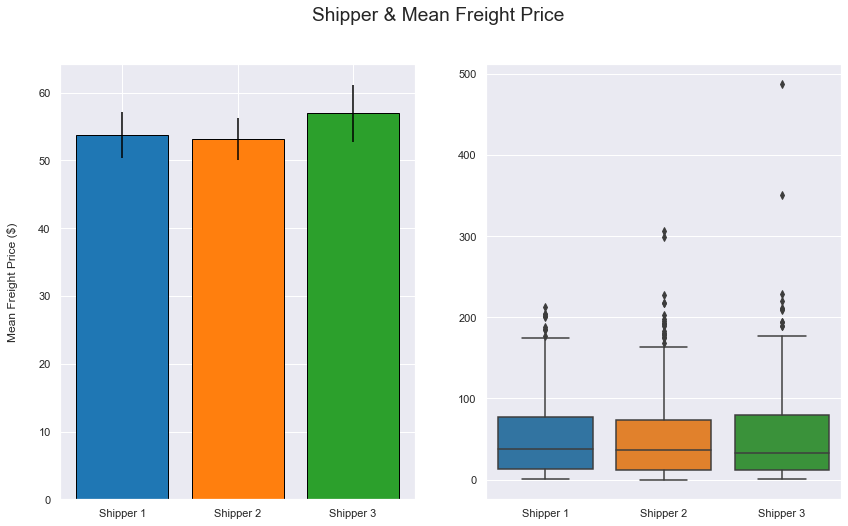

In [34]:
# Plot bar chart comparing sample means of shippers

plt.figure(figsize=(14, 8))
sns.set_style('darkgrid')
sns.set_context(context='notebook')
plt.subplot(121)
for k, v in q2_data.items():
    plt.bar(x=k, height=np.mean(v), yerr=stats.sem(v), linewidth=1, edgecolor='black')
plt.ylabel('Mean Freight Price ($)', labelpad=20)
plt.subplot(122)
sns.boxplot(data=out_rem_data)
plt.rcParams.update({'font.size': 16})
plt.xticks(ticks=[0,1,2], labels=['Shipper 1', 'Shipper 2', 'Shipper 3'])
plt.suptitle('Shipper & Mean Freight Price')
plt.show();

## Conclusion: Question 2

To test the hypothesis that there is no significant difference in freight price between shippers, I used a one-way ANOVA test, a parametric test used to compare means of two or more samples. I attempted outlier removal in an attempt to remove the bias of very expensive shipments. While the sample data were not normally distributed, the size of each sample was large enough to ignore this assumption for one-way ANOVA. Also, since the sample sizes were not 'sharply' different, the homogeneity of variance assumption for one-way ANOVA could also be ignored.

The results of this test indicate that, at alpha = 0.05, we cannot reject the null hypothesis that there is no signficant difference in freight prices between shippers.

The result of a non-parametric Krustal-Wallis test on the same samples confirms this result.

# Question # 3: Employee & Orders per Customer
Question (3) Does the specific employee have a statistically significant effect on the number of repeat orders their customers make?

Null Hypothesis: The specific employee has no statistically signficant effect on the number of repeat orders a customer makes.

Alternative Hypothesis: The specific employee has a signficant impact on the number of repeat orders a customer makes.

## Obtain
Need info from Order table

In [35]:
cur.execute("""SELECT CustomerId, EmployeeId
            FROM 'Order'
            ;""")
q3df = pd.DataFrame(cur.fetchall())
q3df.columns = [x[0] for x in cur.description]
q3df

,CustomerId,EmployeeId
0,VINET,5
1,TOMSP,6
2,HANAR,4
3,VICTE,3
4,SUPRD,4
...,...,...
825,PERIC,2
826,SIMOB,7
827,RICSU,8
828,BONAP,4


## Scrub / Explore
Grouping data by EmployeeID and then by CustomerId, and totaling the number of orders each customer has made.

In [36]:
# Calculate number of orders each customer has made with each unique employee

cust_ord_by_emp = q3df.groupby(['EmployeeId', 'CustomerId'])['CustomerId'].count()
df = cust_ord_by_emp.to_frame()
df

CustomerId
EmployeeId CustomerId            
1          ALFKI                2
           ANTO                 1
           AROUT                3
           BERGS                4
           BONAP                3
...                           ...
9          SAVEA                1
           SUPRD                1
           TRAIH                1
           WARTH                1
           WELLI                1

[464 rows x 1 columns]

In [37]:
# Create dictionary for number of times customers returned for each employee
rc_dict = {}

for i in range(1,10):
    key = f'Employee {i}'
    vals = cust_ord_by_emp.loc[i].to_list()
    rc_dict[key] = vals
    
rc_dict

{'Employee 1': [2,
  1,
  3,
  4,
  3,
  2,
  1,
  1,
  1,
  2,
  1,
  2,
  5,
  1,
  1,
  5,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  3,
  2,
  1,
  1,
  1,
  4,
  1,
  1,
  1,
  3,
  2,
  1,
  2,
  3,
  1,
  1,
  1,
  1,
  4,
  1,
  5,
  2,
  2,
  1,
  1,
  2,
  6,
  2,
  2,
  1,
  1,
  4,
  2,
  4,
  2,
  1,
  1,
  1,
  1,
  1,
  2],
 'Employee 2': [1,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  3,
  1,
  3,
  1,
  2,
  1,
  1,
  1,
  1,
  3,
  1,
  2,
  1,
  2,
  2,
  1,
  1,
  2,
  1,
  3,
  1,
  1,
  1,
  1,
  2,
  2,
  3,
  2,
  1,
  6,
  1,
  2,
  2,
  1,
  1,
  4,
  1,
  2,
  1,
  2,
  1,
  1,
  2,
  1,
  1,
  2,
  1,
  3,
  1,
  3],
 'Employee 3': [1,
  2,
  3,
  2,
  6,
  1,
  2,
  3,
  4,
  2,
  1,
  1,
  4,
  1,
  1,
  2,
  1,
  1,
  1,
  1,
  2,
  1,
  3,
  4,
  2,
  2,
  5,
  1,
  2,
  1,
  1,
  4,
  3,
  3,
  1,
  1,
  4,
  2,
  2,
  1,
  3,
  1,
  1,
  1,
  5,
  4,
  2,
  1,
  2,
  1,
  1,
  2,
  1,
  2,
  1,
  1,
  1,
  3,
  1,
  1,
  3,
  3,
  1],
 'Employee 4': [2,
 

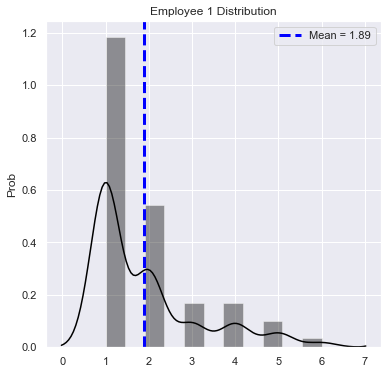

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.3427191580817066e-09

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.1810664560047295e-05

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 6.942372674264902 > Critical Value 0.746


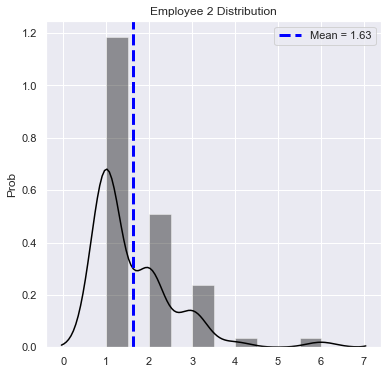

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 4.252184715447527e-10

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.0579941980948511e-09

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 6.786922898467964 > Critical Value 0.742


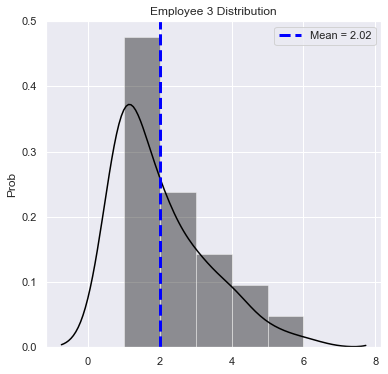

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 5.075458631154106e-08

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 0.0009242699497270381

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 4.966299766639082 > Critical Value 0.744


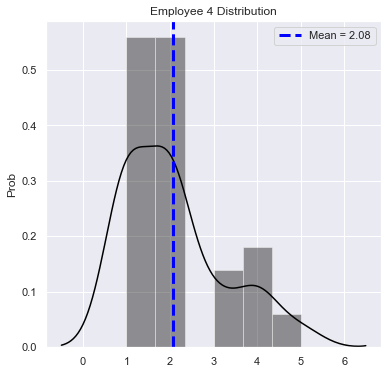

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.551854016985544e-08

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 0.004456274912399142

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 5.336173137905192 > Critical Value 0.75


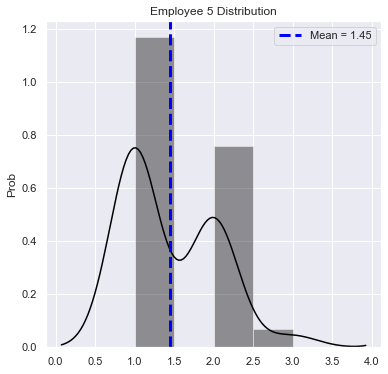

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.70596024418046e-06

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 0.16497084457863204

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 4.2516345512440665 > Critical Value 0.71


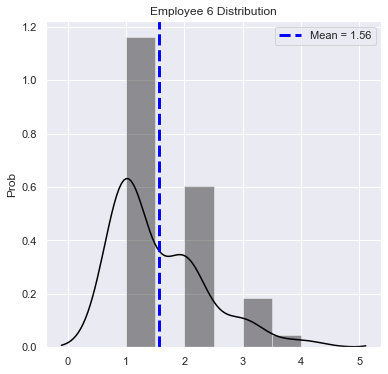

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.1312334891044884e-07

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 0.0017536125001405966

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 5.049793488749515 > Critical Value 0.729


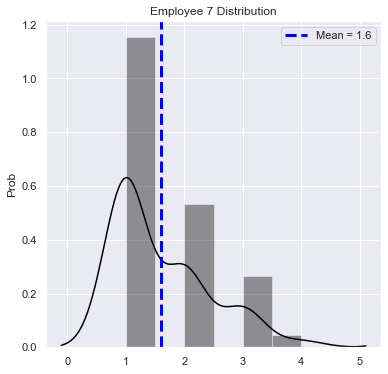

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.0546412454459642e-07

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 0.00941445460730022

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 5.212481947195599 > Critical Value 0.731


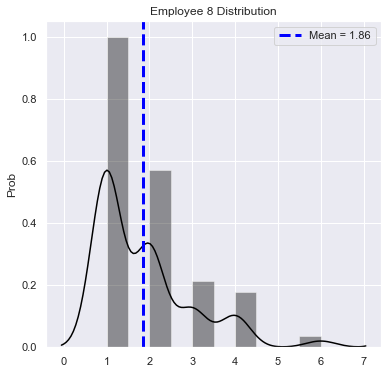

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 3.10819849858035e-08

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.0480181258595363e-05

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 4.990979546633653 > Critical Value 0.74


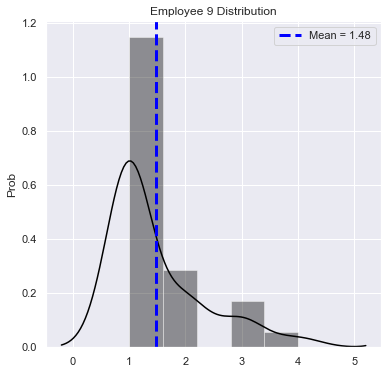

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 3.503367622670339e-07

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 0.0006212282294237795

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 4.710159952305212 > Critical Value 0.71


In [38]:
# Check out customer order count distributions for each employee

for k, v in rc_dict.items():
    dist = DistChecker(v, k)
    dist.plot_dist()
    dist.norm_tests()

Since none of these distributions are normally distributed, and the sample sizes are relatively small, I will be using the Kruskal-Wallis test two determine if a significant difference exists between two or more groups. These data meet the rule that each sample must have >= 5 observations.

## Test: Kruskal-Wallis Test

In [39]:
rc_dict['Employee 1']

st, p_val = stats.kruskal(
    rc_dict['Employee 1'], rc_dict['Employee 2'], rc_dict['Employee 3'], rc_dict['Employee 4'],
    rc_dict['Employee 5'], rc_dict['Employee 6'], rc_dict['Employee 7'], rc_dict['Employee 8'],
    rc_dict['Employee 9'])
alpha = 0.05
if p_val < 0.05:
    print('KRUSKAL-WALLIS TEST RESULT:\n')
    print(
        f'The null hypothesis IS rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')
else:
    print('KRUSKAL-WALLIS TEST RESULT:\n')
    print(
        f'The null hypothesis is NOT rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')

KRUSKAL-WALLIS TEST RESULT:

The null hypothesis IS rejected at alpha=0.05, with a p-value of 0.034


The Kruskal-Wallis Test detected a signficant difference between medians of at least two samples. 

## Post-Hoc Test: Dunn's Test
After a signficant Kruskal-Wallis Test result, I am using Dunn's Test for multiple comparisons of mean rank sums to determine which groups are significantly different.

In [40]:
sp.posthoc_dunn(q3df, group_col='EmployeeId', val_col='CustomerId')

,1,2,3,4,5,6,7,8,9
1,-1.000000,0.113321,0.228820,0.561362,0.128276,0.907208,0.841118,0.722871,0.022942
2,0.113321,-1.000000,0.006525,0.027643,0.761408,0.142705,0.233107,0.234110,0.000749
3,0.228820,0.006525,-1.000000,0.491586,0.017202,0.372913,0.217347,0.131457,0.155351
4,0.561362,0.027643,0.491586,-1.000000,0.049241,0.720106,0.483704,0.354229,0.053264
5,0.128276,0.761408,0.017202,0.049241,-1.000000,0.141285,0.212489,0.219309,0.001869
6,0.907208,0.142705,0.372913,0.720106,0.141285,-1.000000,0.779858,0.678482,0.048664
7,0.841118,0.233107,0.217347,0.483704,0.212489,0.779858,-1.000000,0.909153,0.024767
8,0.722871,0.234110,0.131457,0.354229,0.219309,0.678482,0.909153,-1.000000,0.013029
9,0.022942,0.000749,0.155351,0.053264,0.001869,0.048664,0.024767,0.013029,-1.000000


In [163]:
# Creating final dataframe for question 3 swarm plot

df1 = pd.DataFrame([])
df2 = pd.DataFrame([])
df3 = pd.DataFrame([])
df4 = pd.DataFrame([])
df5 = pd.DataFrame([])
df6 = pd.DataFrame([])
df7 = pd.DataFrame([])
df8 = pd.DataFrame([])
df9 = pd.DataFrame([])

df1['Counts'] = rc_dict['Employee 1']
df1['Emp'] = 'Employee 1'
df2['Counts'] = rc_dict['Employee 2']
df2['Emp'] = 'Employee 2'
df3['Counts'] = rc_dict['Employee 3']
df3['Emp'] = 'Employee 3'
df4['Counts'] = rc_dict['Employee 4']
df4['Emp'] = 'Employee 4'
df5['Counts'] = rc_dict['Employee 5']
df5['Emp'] = 'Employee 5'
df6['Counts'] = rc_dict['Employee 6']
df6['Emp'] = 'Employee 6'
df7['Counts'] = rc_dict['Employee 7']
df7['Emp'] = 'Employee 7'
df8['Counts'] = rc_dict['Employee 8']
df8['Emp'] = 'Employee 8'
df9['Counts'] = rc_dict['Employee 9']
df9['Emp'] = 'Employee 9'

df19 = pd.concat([df1, df9])
df29 = pd.concat([df2, df9])
df39 = pd.concat([df3, df9])
df49 = pd.concat([df4, df9])
df59 = pd.concat([df5, df9])
df69 = pd.concat([df6, df9])
df79 = pd.concat([df7, df9])
df89 = pd.concat([df8, df9])


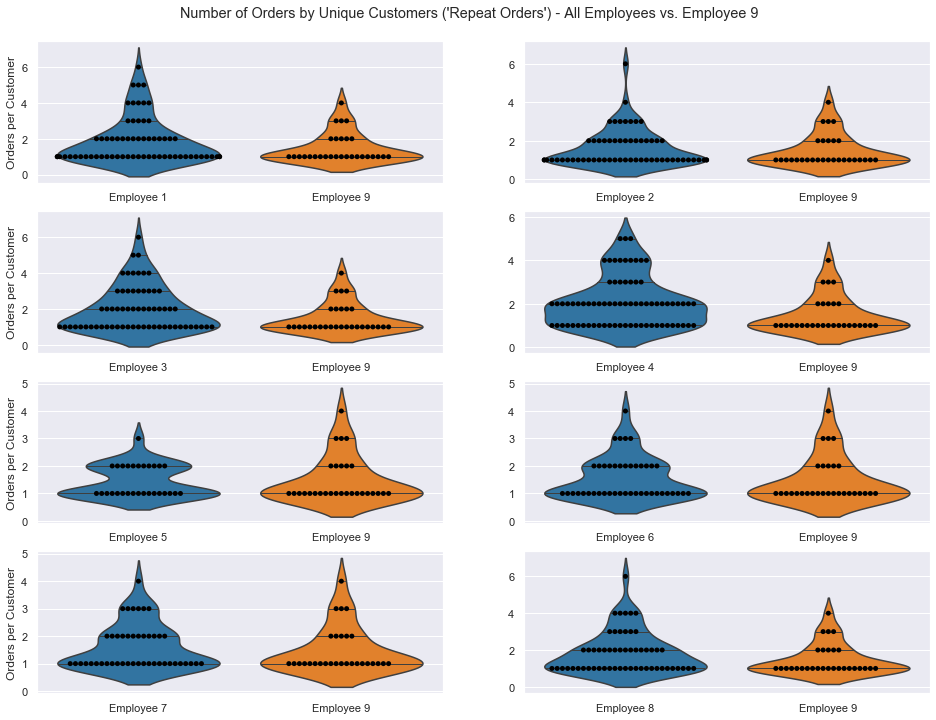

In [164]:
# Combination violinplot and swarmplot for Employee 9 vs all other employees

plt.figure(figsize=(16,12))
sns.set_style('darkgrid')
sns.set_context('notebook')
plt.subplot(421)
sns.swarmplot(data=df19, x='Emp', y='Counts', color='black')
sns.violinplot(data=df19, x='Emp', y='Counts', scale='width', inner='stick')
plt.ylabel('Orders per Customer')
plt.xlabel('')
plt.subplot(422)
sns.swarmplot(data=df29, x='Emp', y='Counts', color='black')
sns.violinplot(data=df29, x='Emp', y='Counts', scale='width', inner='stick')
plt.ylabel('')
plt.xlabel('')
plt.subplot(423)
sns.swarmplot(data=df39, x='Emp', y='Counts', color='black')
sns.violinplot(data=df39, x='Emp', y='Counts', scale='width', inner='stick')
plt.ylabel('Orders per Customer')
plt.xlabel('')
plt.subplot(424)
sns.swarmplot(data=df49, x='Emp', y='Counts', color='black')
sns.violinplot(data=df49, x='Emp', y='Counts', scale='width', inner='stick')
plt.ylabel('')
plt.xlabel('')
plt.subplot(425)
sns.swarmplot(data=df59, x='Emp', y='Counts', color='black')
sns.violinplot(data=df59, x='Emp', y='Counts', scale='width', inner='stick')
plt.ylabel('Orders per Customer')
plt.xlabel('')
plt.subplot(426)
sns.swarmplot(data=df69, x='Emp', y='Counts', color='black')
sns.violinplot(data=df69, x='Emp', y='Counts', scale='width', inner='stick')
plt.ylabel('')
plt.xlabel('')
plt.subplot(427)
sns.swarmplot(data=df79, x='Emp', y='Counts', color='black')
sns.violinplot(data=df79, x='Emp', y='Counts', scale='width', inner='stick')
plt.ylabel('Orders per Customer')
plt.xlabel('')
plt.subplot(428)
sns.swarmplot(data=df89, x='Emp', y='Counts', color='black')
sns.violinplot(data=df89, x='Emp', y='Counts', scale='width', inner='stick')
plt.ylabel('')
plt.xlabel('')
plt.suptitle("Number of Orders by Unique Customers ('Repeat Orders') - All Employees vs. Employee 9", y=0.92)
plt.show();


## Interpretation / Conclusion: Question 3

Following the signficant result of the Kruskal-Wallis Test, the post-hoc Dunn's test revealed that the group "Employee 9" is significantly different in the number of orders per unique customer than nearly every other employee (with the exception of Employee 3). The combined Swarm & Violin plots above reveal that Employee 9 generally has a much lower proportion of 'repeat customers' (customers who have made more than 1 order with an employee) than other employees. This is a target for future improvement, through customer service training, for Employee 9 to increase their 'repeat customer' order rate.

# Question # 4: Time of Year & Quantity Product in Order

## Obtain
Need to obtain the Order and OrderDetail tables

In [44]:
# Obtain OrderDetail table, create a pandas dataframe
cur.execute("""SELECT * FROM OrderDetail""")
df_od = pd.DataFrame(cur.fetchall())
df_od.columns = [x[0] for x in cur.description]
df_od.drop(labels='Id', inplace=True, axis=1)
df_od.head()

,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248,11,14.0,12,0.0
1,10248,42,9.8,10,0.0
2,10248,72,34.8,5,0.0
3,10249,14,18.6,9,0.0
4,10249,51,42.4,40,0.0


In [43]:
# Obtain Order table, create a pandas dataframe
cur.execute("""SELECT * FROM 'Order'""")
df_o = pd.DataFrame(cur.fetchall())
df_o.columns = [x[0] for x in cur.description]
df_o.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


## Scrub / Explore

In [65]:
# Now join Order and OrderDetail, keeping only OrderId, ProductId, Quantity, OrderDate

cur.execute("""SELECT OrderId, ProductId, Quantity, OrderDate
            FROM 'Order' as o
            JOIN OrderDetail as od
            ON o.Id = od.OrderId
            ;""")
ordersfull_df = pd.DataFrame(cur.fetchall())
ordersfull_df.columns = [x[0] for x in cur.description]
ordersfull_df

,OrderId,ProductId,Quantity,OrderDate
0,10248,11,12,2012-07-04
1,10248,42,10,2012-07-04
2,10248,72,5,2012-07-04
3,10249,14,9,2012-07-05
4,10249,51,40,2012-07-05
...,...,...,...,...
2150,11077,64,2,2014-05-06
2151,11077,66,1,2014-05-06
2152,11077,73,2,2014-05-06
2153,11077,75,4,2014-05-06


In [69]:
# What are the min and max order dates to deal with?

print(f'Max (latest) date is {ordersfull_df.OrderDate.max()}')
print(f'Min (earliest) date is {ordersfull_df.OrderDate.min()}')

Max (latest) date is 2014-05-06
Min (earliest) date is 2012-07-04


In [87]:
# Use list comprehension to create a column: Quarter (of year in which order was placed)

for i, x in enumerate(ordersfull_df['OrderDate']):
    if (x >= '2012-07-01') & (x <= '2012-09-30'):
        ordersfull_df['Q'][i] = 3
    elif (x >= '2012-10-01') & (x <= '2012-12-31'):
        ordersfull_df['Q'][i] = 4
    elif (x >= '2013-01-01') & (x <= '2013-03-31'):
        ordersfull_df['Q'][i] = 1
    elif (x >= '2013-04-01') & (x <= '2013-06-30'):
        ordersfull_df['Q'][i] = 2
    elif (x >= '2013-07-01') & (x <= '2013-09-30'):
        ordersfull_df['Q'][i] = 3
    elif (x >= '2013-10-01') & (x <= '2013-12-31'):
        ordersfull_df['Q'][i] = 4
    elif (x >= '2014-01-01') & (x <= '2014-03-31'):
        ordersfull_df['Q'][i] = 1
    elif (x >= '2014-04-01') & (x <= '2014-06-30'):
        ordersfull_df['Q'][i] = 2
        
ordersfull_df.head()

C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dougl\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\doug

,OrderId,ProductId,Quantity,OrderDate,Q
0,10248,11,12,2012-07-04,3
1,10248,42,10,2012-07-04,3
2,10248,72,5,2012-07-04,3
3,10249,14,9,2012-07-05,3
4,10249,51,40,2012-07-05,3


In [109]:
# Create variables for quantities in each order for each quarter
Q1 = ordersfull_df[ordersfull_df['Q'] == 1].Quantity
Q2 = ordersfull_df[ordersfull_df['Q'] == 2].Quantity
Q3 = ordersfull_df[ordersfull_df['Q'] == 3].Quantity
Q4 = ordersfull_df[ordersfull_df['Q'] == 4].Quantity

In [113]:
# Save these to a dictionary with names for easy access
quarters = [Q1, Q2, Q3, Q4]
q_names = ['1st Quarter', '2nd Quarter', '3rd Quarter', '4th Quarter']

q_dict = dict(zip(q_names, quarters))
q_dict

{'1st Quarter': 405     21
 406     35
 407     30
 408     18
 409     70
         ..
 1911    60
 1912    40
 1913    40
 1914    15
 1915     4
 Name: Quantity, Length: 693, dtype: int64, '2nd Quarter': 646     60
 647     20
 648     15
 649     10
 650     10
         ..
 2150     2
 2151     1
 2152     2
 2153     4
 2154     2
 Name: Quantity, Length: 492, dtype: int64, '3rd Quarter': 0       12
 1       10
 2        5
 3        9
 4       40
         ..
 1150    30
 1151    15
 1152    50
 1153    10
 1154     6
 Name: Quantity, Length: 441, dtype: int64, '4th Quarter': 185     20
 186      6
 187      8
 188     14
 189     30
         ..
 1459    10
 1460    20
 1461     2
 1462    15
 1463     1
 Name: Quantity, Length: 529, dtype: int64}

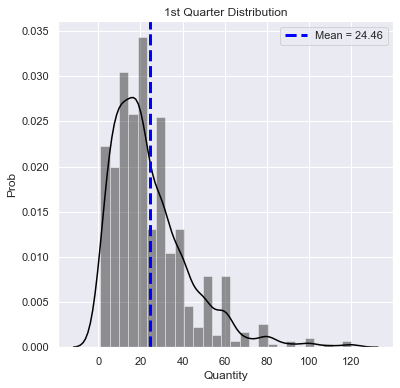

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.547062258044066e-23

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 9.373573227575504e-50

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 21.170675314487426 > Critical Value 0.783


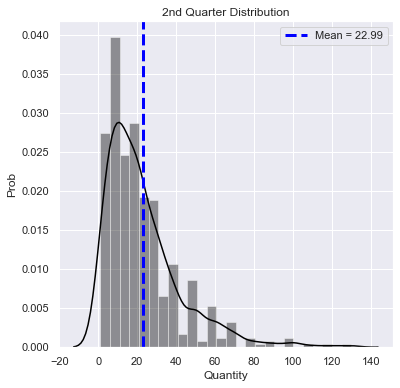

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 5.204523075058833e-22

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.555730059276382e-43

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 19.641907177172413 > Critical Value 0.781


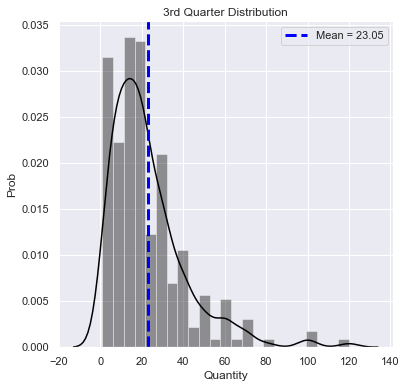

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 7.77799222453319e-21

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 4.3500761680111635e-41

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 16.78838825289381 > Critical Value 0.78


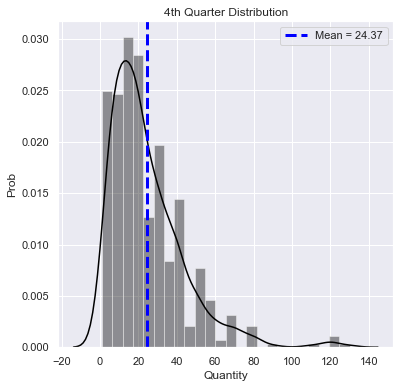

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.853270514248011e-22

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 1.4844186058916446e-48

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 17.653639748422393 > Critical Value 0.781


In [114]:
# Check out quantity of products ordered distributions for each quarter

for k, v in q_dict.items():
    dist = DistChecker(v, k)
    dist.plot_dist()
    dist.norm_tests()

It appears that all groups have high outliers that may be influencing the means / normality of distributions. I will perform outlier removal before proceeding with significance testing, using IQR scores.

In [125]:
out_q = []

for quarter in quarters:
    q1, q3 = np.percentile(a=quarter, q=[25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    fr_out = quarter.to_list()
    for obs in fr_out:
        if obs < lower_bound or obs > upper_bound:
            fr_out.remove(obs)
        else: 
            continue
    out_q.append(fr_out)

#     outliers.append(list(
#         df_scrub[(df_scrub[col] < lower_bound) | (df_scrub[col] > upper_bound)].index))


out_q

[[21,
  35,
  30,
  18,
  20,
  60,
  60,
  21,
  30,
  40,
  30,
  50,
  10,
  30,
  42,
  5,
  2,
  30,
  15,
  15,
  10,
  6,
  35,
  12,
  12,
  49,
  16,
  25,
  40,
  9,
  20,
  24,
  40,
  14,
  18,
  50,
  2,
  20,
  20,
  10,
  20,
  50,
  2,
  36,
  35,
  60,
  55,
  16,
  15,
  60,
  20,
  20,
  2,
  8,
  20,
  4,
  30,
  15,
  10,
  2,
  14,
  20,
  60,
  49,
  30,
  10,
  20,
  5,
  7,
  35,
  20,
  40,
  35,
  45,
  50,
  30,
  50,
  50,
  30,
  10,
  40,
  28,
  6,
  18,
  10,
  12,
  10,
  5,
  40,
  30,
  24,
  15,
  15,
  20,
  15,
  15,
  16,
  6,
  30,
  45,
  49,
  24,
  50,
  30,
  60,
  6,
  12,
  10,
  15,
  8,
  30,
  6,
  15,
  12,
  20,
  3,
  15,
  40,
  35,
  2,
  6,
  20,
  14,
  20,
  35,
  20,
  6,
  35,
  28,
  55,
  15,
  15,
  25,
  20,
  20,
  10,
  20,
  50,
  25,
  30,
  40,
  21,
  36,
  30,
  30,
  20,
  15,
  50,
  16,
  20,
  40,
  21,
  4,
  40,
  28,
  60,
  1,
  21,
  21,
  50,
  16,
  3,
  30,
  20,
  25,
  18,
  20,
  30,
  25,
  10,
  5,


In [126]:
q_dict2 = dict(zip(q_names, out_q))
q_dict2['1st Quarter']

[21,
 35,
 30,
 18,
 20,
 60,
 60,
 21,
 30,
 40,
 30,
 50,
 10,
 30,
 42,
 5,
 2,
 30,
 15,
 15,
 10,
 6,
 35,
 12,
 12,
 49,
 16,
 25,
 40,
 9,
 20,
 24,
 40,
 14,
 18,
 50,
 2,
 20,
 20,
 10,
 20,
 50,
 2,
 36,
 35,
 60,
 55,
 16,
 15,
 60,
 20,
 20,
 2,
 8,
 20,
 4,
 30,
 15,
 10,
 2,
 14,
 20,
 60,
 49,
 30,
 10,
 20,
 5,
 7,
 35,
 20,
 40,
 35,
 45,
 50,
 30,
 50,
 50,
 30,
 10,
 40,
 28,
 6,
 18,
 10,
 12,
 10,
 5,
 40,
 30,
 24,
 15,
 15,
 20,
 15,
 15,
 16,
 6,
 30,
 45,
 49,
 24,
 50,
 30,
 60,
 6,
 12,
 10,
 15,
 8,
 30,
 6,
 15,
 12,
 20,
 3,
 15,
 40,
 35,
 2,
 6,
 20,
 14,
 20,
 35,
 20,
 6,
 35,
 28,
 55,
 15,
 15,
 25,
 20,
 20,
 10,
 20,
 50,
 25,
 30,
 40,
 21,
 36,
 30,
 30,
 20,
 15,
 50,
 16,
 20,
 40,
 21,
 4,
 40,
 28,
 60,
 1,
 21,
 21,
 50,
 16,
 3,
 30,
 20,
 25,
 18,
 20,
 30,
 25,
 10,
 5,
 28,
 12,
 8,
 15,
 40,
 35,
 2,
 30,
 15,
 8,
 30,
 20,
 18,
 12,
 12,
 12,
 18,
 21,
 10,
 35,
 60,
 42,
 2,
 12,
 15,
 21,
 20,
 20,
 30,
 28,
 60,
 30,
 30,
 12,
 24,


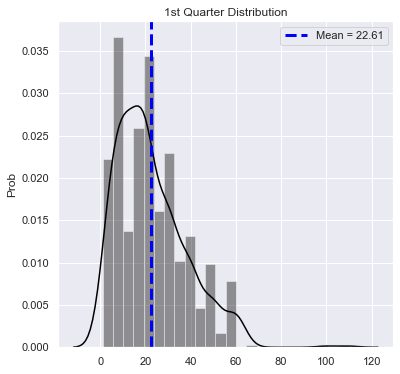

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 5.705675247467873e-19

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 3.177090698584879e-29

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 13.92138167452299 > Critical Value 0.782
N = 672


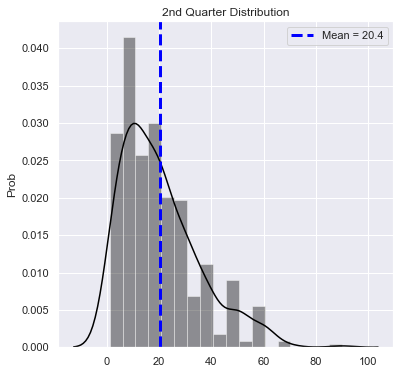

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 5.4461926225538e-16

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 9.711319134489651e-18

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 11.189396784354983 > Critical Value 0.78
N = 472


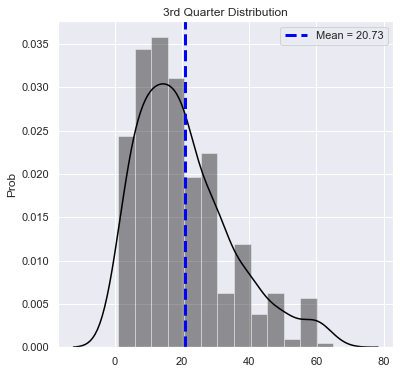

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 3.9548476527071635e-14

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 3.719281922153481e-12

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 9.066207714290556 > Critical Value 0.78
N = 425


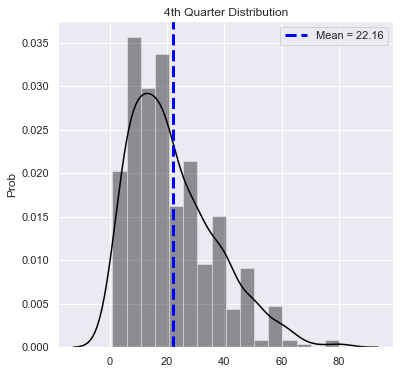

SHAPIRO-WILK TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 3.522732735874198e-15

D'AGOSTINO-PEARSON TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED at p = 2.0676694236247593e-14

ANDERSON-DARLING TEST at alpha = 0.05:
The null hypothesis that sample was drawn from a normal distribution is REJECTED.
Test Statistic: 10.41822771237753 > Critical Value 0.781
N = 511


In [130]:
for k, v in q_dict2.items():
    dist = DistChecker(v, k)
    dist.plot_dist()
    dist.norm_tests()
    print(f'N = {len(v)}')

Do these data meet the requirements for a one-way ANOVA test?

1) Is each record in data distinct and independent? -> Yes

2) Are samples normally distriuted, or is N >= 25? -> Yes

3) Is homogeneity of variance present? (Only needed for sharply unequal sample sizes) -> No (But sample sizes are not 'SHARPLY' unequal (672 vs 472 vs 425 vs 511), so this assumption is met.)

Therefore, I conclude that the one-way ANOVA is suitable for these samples, but I will also perform a Kruskal-Wallis test as a non-parametric check.

## Test: One-Way ANOVA (Kruskal-Wallis)

In [124]:
f_st, p_val = stats.f_oneway(
    q_dict2['1st Quarter'], q_dict2['2nd Quarter'], q_dict2['3rd Quarter'], q_dict2['4th Quarter'])
alpha = 0.05
if p_val < 0.05:
    print('ONE-WAY ANOVA TEST RESULT:\n')
    print(
        f'The null hypothesis IS rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')
else:
    print('ONE-WAY ANOVA TEST RESULT:\n')
    print(
        f'The null hypothesis is NOT rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')

ONE-WAY ANOVA TEST RESULT:

The null hypothesis IS rejected at alpha=0.05, with a p-value of 0.041


In [127]:
st, p_val = stats.kruskal(q_dict2['1st Quarter'], q_dict2['2nd Quarter'], q_dict2['3rd Quarter'], q_dict2['4th Quarter'])
alpha = 0.05
if p_val <0.05:
    print('KRUSKAL-WALLIS TEST RESULT:\n')
    print(f'The null hypothesis IS rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')
else:
    print('KRUSKAL-WALLIS TEST RESULT:\n')
    print(f'The null hypothesis is NOT rejected at alpha={alpha}, with a p-value of {round(p_val,3)}')

KRUSKAL-WALLIS TEST RESULT:

The null hypothesis IS rejected at alpha=0.05, with a p-value of 0.028


## Post-Hoc Test: Tukey's HSD

In [167]:
df4_1 = pd.DataFrame([])
df4_1['Quantity'] = q_dict2['1st Quarter']
df4_1['Q'] = 1
df4_2 = pd.DataFrame([])
df4_2['Quantity'] = q_dict2['2nd Quarter']
df4_2['Q'] = 2
df4_3 = pd.DataFrame([])
df4_3['Quantity'] = q_dict2['3rd Quarter']
df4_3['Q'] = 3
df4_4 = pd.DataFrame([])
df4_4['Quantity'] = q_dict2['4th Quarter']
df4_4['Q'] = 4

df4 = pd.concat([df4_1, df4_2, df4_3, df4_4])

In [168]:
q4b_result = sm.stats.multicomp.pairwise_tukeyhsd(endog=df4.Quantity, groups=df4.Q)
q4b_result.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-2.2088,0.066,-4.5135,0.0958,False
1,3,-1.8754,0.1781,-4.2537,0.5029,False
1,4,-0.4486,0.9,-2.701,1.8037,False
2,3,0.3335,0.9,-2.2326,2.8995,False
2,4,1.7602,0.2515,-0.6896,4.21,False
3,4,1.4267,0.4656,-1.0925,3.946,False


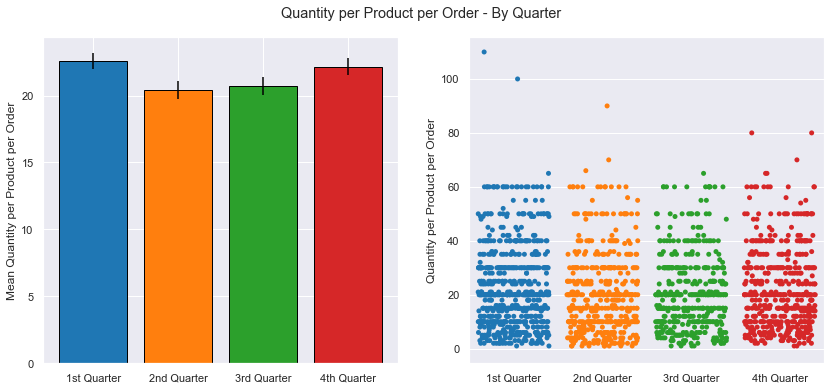

In [183]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.ylabel('Mean Quantity per Product per Order')
for k,v in q_dict2.items():
    plt.bar(x=k, height=np.mean(v), yerr=stats.sem(v), linewidth=1, edgecolor='black')
plt.subplot(122)
sns.stripplot(x=df4.Q, y=df4.Quantity, jitter=0.4)
plt.xticks(ticks=[0,1,2,3], labels=['1st Quarter', '2nd Quarter', '3rd Quarter', '4th Quarter'])
plt.ylabel('Quantity per Product per Order')
plt.xlabel('')
plt.suptitle('Quantity per Product per Order - By Quarter', y=0.95)
plt.show()